#Introduction of Recurrent Neural Network

## import all required library

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential
from scipy import stats

from pprint import pprint
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
# pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'


# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

tf.random.set_seed(100)

/var/folders/hf/0mp7k_vd30z8kr8nkwwh037m0000gn/T/ipykernel_64074/2203271861.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## define our own functions

In [2]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

## Recurrent Neural Network Fundamentals

In [3]:
a = np.arange(100)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
a = a.reshape((len(a), -1))
a.shape

(100, 1)

In [5]:
a[:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
np.min( [5, len(g)] )

5

In [8]:
'''
TimeseriesGenerator is to make a time series, i.e., 0,1,2,3,4,5,6,...,99,
to lagged data sample and target, such as, 
if lag=3 (today's stock price is correlated with prices in prior three days)
X            y
0,1,2 =>     3
1,2,3 =>     4
2,3,4 =>     5
......
96,97,98 => 99
'''

lags = 3
g = TimeseriesGenerator(a, a, length=lags, batch_size=1)

# to print the first five examples of generated X and y
for i in range( np.min( [5, len(g)] ) ):
    x,y = g[i]
    print('%s => %s' % (x, y))

[[[0]
  [1]
  [2]]] => [[3]]
[[[1]
  [2]
  [3]]] => [[4]]
[[[2]
  [3]
  [4]]] => [[5]]
[[[3]
  [4]
  [5]]] => [[6]]
[[[4]
  [5]
  [6]]] => [[7]]


In [9]:
g

In [9]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [10]:
model = Sequential()

# SimpleRNN is the basic structure of recurrent neural network with no gates
model.add(SimpleRNN(100, activation='relu',
                    input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adagrad', loss='mse',
              metrics=['mae'])

Metal device set to: Apple M1


2023-01-23 00:35:06.181985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-23 00:35:06.182514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%time
h = model.fit(g, epochs=1000, steps_per_epoch=5,
            verbose=False)

2023-01-23 00:35:06.660702: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-23 00:35:07.108437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 17s, sys: 51.7 s, total: 2min 9s
Wall time: 1min 10s


In [13]:
type(h.history)

dict

In [14]:
# transform a dict to a Pandas dataframe
res = pd.DataFrame(h.history)
res.tail(3)

,loss,mae
997,1.190909,0.815756
998,0.334959,0.505170
999,1.420561,1.068646


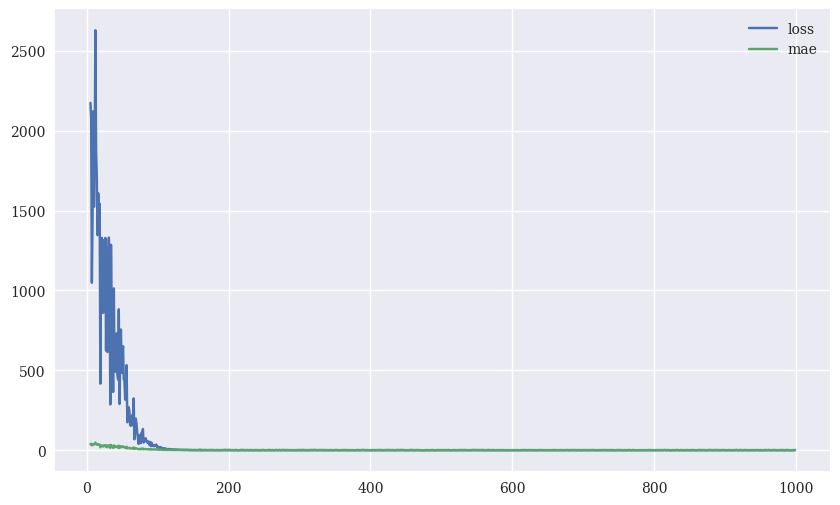

In [15]:
res.iloc[5:].plot(figsize=(10, 6), style=['-', '-']);

In [16]:
# testing: X=21,22,23 => y=?
x = np.array([21, 22, 23]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

2023-01-23 00:36:17.968392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23

In [17]:
# testing: X=87,88,89 => y=?
x = np.array([87, 88, 89]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

91

In [18]:
x = np.array([187, 188, 189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

193

In [19]:
x = np.array([1187, 1188, 1189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

1222

## Modelling FX by RNN

### Modelling FX rate

### import google.colab for read from google drive

In [21]:
'''to read data, upload data (csv, xlsx, txt...) to your google drive, and mount google drive to your Colab environment, 
so that you can use Pandas to read the data directly
''' 
# from google.colab import drive

# mount the Google drive as a path that you can work on 
# drive.mount('/drive')

# the file path always starts with '/drive/My Drive/', you can define your own file directory
# raw = pd.read_csv('/drive/My Drive/Colab Notebooks/Data/eur_usd.csv', parse_dates=True)

raw = pd.read_csv('data/eur_usd.csv', parse_dates=True)
print(raw.describe())


               HIGH           LOW          OPEN         CLOSE
count  96526.000000  96526.000000  96526.000000  96526.000000
mean       1.107178      1.106942      1.107057      1.107061
std        0.006406      0.006400      0.006404      0.006401
min        1.088100      1.087700      1.087900      1.087900
25%        1.102100      1.101900      1.102100      1.102000
50%        1.107700      1.107500      1.107600      1.107600
75%        1.112100      1.111800      1.111900      1.111900
max        1.123900      1.123600      1.123900      1.123800


In [22]:
print(raw.head())

                  Date    HIGH     LOW    OPEN   CLOSE
0  2019-10-01 00:00:00  1.0899  1.0897  1.0897  1.0899
1  2019-10-01 00:01:00  1.0899  1.0896  1.0899  1.0898
2  2019-10-01 00:02:00  1.0898  1.0896  1.0898  1.0896
3  2019-10-01 00:03:00  1.0898  1.0896  1.0897  1.0898
4  2019-10-01 00:04:00  1.0898  1.0896  1.0897  1.0898


### define some function for modelling FX

In [23]:
# define a function for plotting a time series with a dataframe format

def plot_fin_data( data_x, data_y, leg_txt='price' ):
    # plot financial data, data_x must be transformable to datatime
    %matplotlib inline
    plt.figure(figsize=(10, 6))
    for i in range(data_y.shape[1]):
        plt.plot(pd.to_datetime(data_x), data_y.iloc[:,i], '-')
    plt.xlabel('Date', fontsize=15)
    plt.ylabel(leg_txt, fontsize=15)
    plt.legend([leg_txt], fontsize=15)


In [24]:
# define a function for resampling the high-frequency data
# input argument is the downsample interval: 
# it can be any value with min, h, d, it is 30min by default
def generate_data( freq='10min' ):
    data = pd.DataFrame(raw['CLOSE'])
    data.columns = ['EUR_USD']
    data.index = raw.index
    # resample by freq, take the last value of each bin with NaN value filled
    data = data.resample(freq, label='right').last().ffill()
    return data

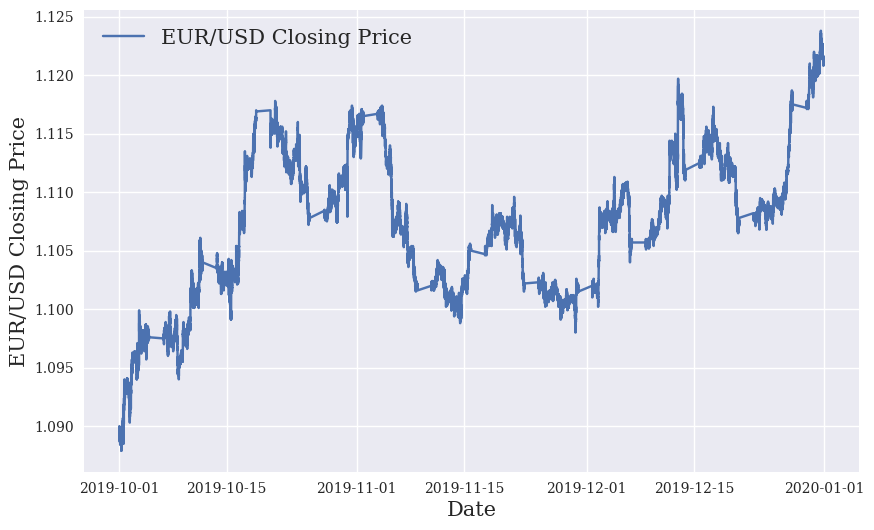

In [25]:
# must pass data_y as a dataframe, NOT a series
plot_fin_data(raw['Date'], raw[['CLOSE']], 'EUR/USD Closing Price')

<AxesSubplot: xlabel='Date'>

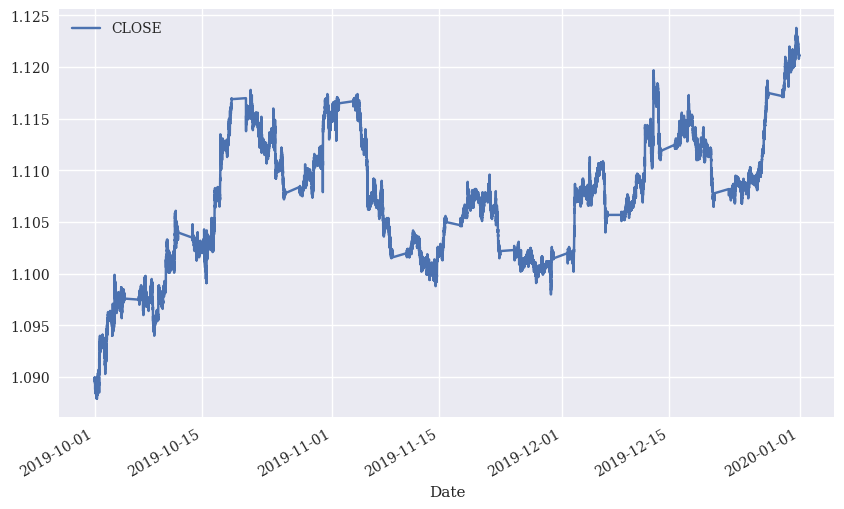

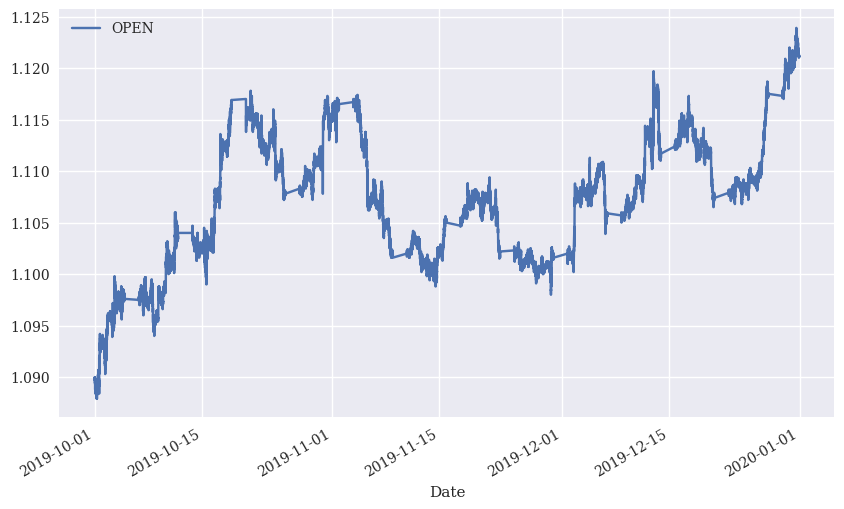

In [26]:
# transform the date to datetime format
raw['Date'] = pd.to_datetime(raw['Date'])
raw.set_index('Date', inplace=True)
raw.head()
# easily plot by dataframe, the index is the x by default
raw.plot( y='CLOSE', figsize=(10, 6) )
raw.plot( y='OPEN', figsize=(10, 6) )

,EUR_USD
Date,
2019-10-01 00:30:00,1.0899
2019-10-01 01:00:00,1.0896
2019-10-01 01:30:00,1.0892
2019-10-01 02:00:00,1.0890
2019-10-01 02:30:00,1.0886


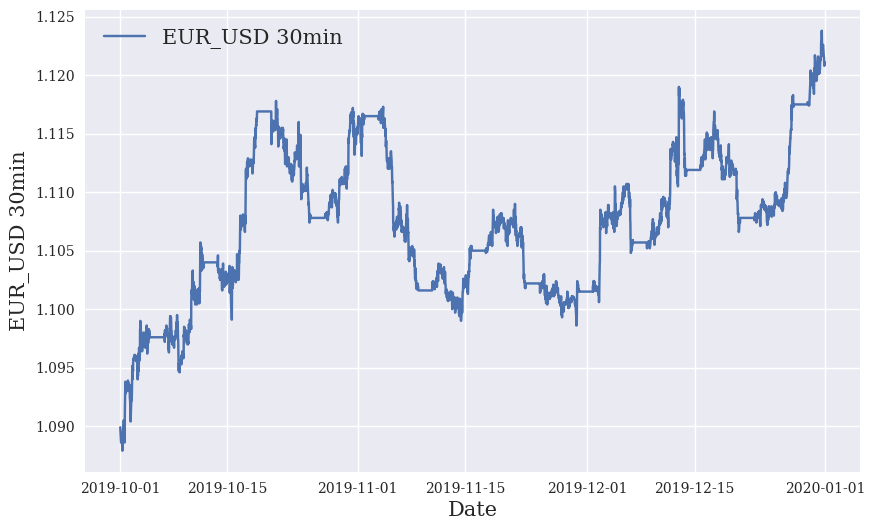

In [27]:
# we can downsample by 10min, 30min, 1h, 2h, 1d, 10d etc
# you can also try down sample to 2 days and see how the data looks like
freq = '30min'

# sampling the data by the freq (every 30 min in this example)
data = generate_data( freq )

plot_fin_data(data.index, data[['EUR_USD']], 'EUR_USD '+freq)
data.head()

In [28]:
p = data['EUR_USD'].values
p.shape

(4415,)

In [29]:
p = p.reshape((len(p), -1))
print(p.shape)
print(p[:5])

(4415, 1)
[[1.0899]
 [1.0896]
 [1.0892]
 [1.089 ]
 [1.0886]]


In [30]:
# split the data to training and testing
split = int(len(p)*0.7)

In [31]:
# normalize the train data
train_avg = np.mean(p[:split])
train_std = np.std(p[:split])
train = (p[:split]-train_avg)/train_std

print(f'train FX rate mean: {train_avg:.10f} | train FX rate std: {train_std:.10f}')
print(train[:6])

train FX rate mean: 1.1053564078 | train FX rate std: 0.0062389516
[[-2.4774]
 [-2.5255]
 [-2.5896]
 [-2.6217]
 [-2.6858]
 [-2.6858]]


In [32]:
lags = 3

In [33]:
from keras.preprocessing.sequence import TimeseriesGenerator

''' TimeseriesGenerator is to construct a time series data to be the dataset for training or testing
in this example, we use the prior five FX rate to forecast the next FX rate, 
TimeseriesGenerator construct the features X
[[-2.4774]
  [-2.5255]
  [-2.5896]
  [-2.6217]
  [-2.6858]]
the target y as [-2.6858]

batch_size is batch size defines the number samples that will be fed in each iteration of the model.
The difference between the different values of batch size are the model weight's optimization. 
If batch size is equal to 5, the model update the weights only after reading 5 samples.
'''
g = TimeseriesGenerator(train, train, length=lags, batch_size=5)

# to print the first example of generated X and y
x,y = g[0]
print('%s => %s' % (x, y))

[[[-2.4774]
  [-2.5255]
  [-2.5896]]

 [[-2.5255]
  [-2.5896]
  [-2.6217]]

 [[-2.5896]
  [-2.6217]
  [-2.6858]]

 [[-2.6217]
  [-2.6858]
  [-2.6858]]

 [[-2.6858]
  [-2.6858]
  [-2.6858]]] => [[-2.6217]
 [-2.6858]
 [-2.6858]
 [-2.6858]
 [-2.6537]]


In [34]:
# we create a function for constructing RNN or LSTM model

def create_rnn_model(hu=100, lags=lags, layer='SimpleRNN',
                           features=1, algorithm='estimation'):
    model = Sequential()
    if layer == 'SimpleRNN':
        model.add(SimpleRNN(hu, activation='relu',
                            input_shape=(lags, features)))
    else:
        model.add(LSTM(hu, activation='relu',
                       input_shape=(lags, features)))
    if algorithm == 'estimation':
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model

In [35]:
# define RNN model
model = create_rnn_model()

# you can also try LSTM and see any performance difference from simple RNN
# model = create_rnn_model( layer='LSTM' )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [36]:
# if using LSTM, be aware that a large epochs (i.e., 100 or 150) will be running for long time

%%time
h=model.fit(g, epochs=30, verbose=False)   # steps_per_epoch=10, 

UsageError: Line magic function `%%time` not found.


<AxesSubplot: >

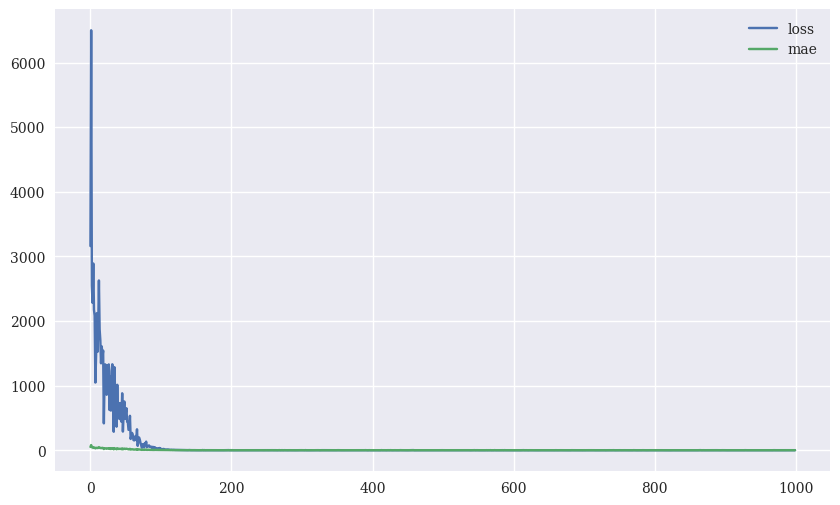

In [37]:
res = pd.DataFrame(h.history)
res.plot(figsize=(10,6))

2023-01-23 00:41:57.154699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


RNN Training MSE=0.0000352060 


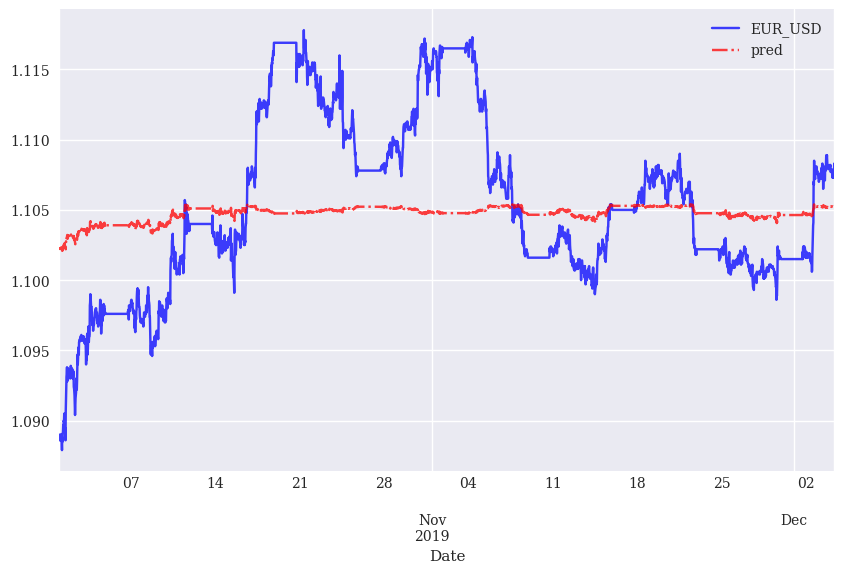

In [38]:
# test on the training data 
y = model.predict(g, verbose=False)

# recover from the normalization
y = (y.flatten()*train_std) + train_avg

data['pred'] = np.nan
data['pred'].iloc[lags:split] = y

# calc the Mean Squared Error
MSE = ((data.iloc[lags:split]['EUR_USD']-data.iloc[lags:split]['pred'])**2).mean()
print(f'RNN Training MSE={MSE:.10f} ')

# plot the raw and predicted values
data[['EUR_USD', 'pred']].iloc[lags:split].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);

In [39]:
# test on the testing data 

# normalize by training mean and std
test = (p[split:]-train_avg)/train_std
test[:5]

g_ = TimeseriesGenerator(test, test, length=lags, batch_size=5)

# to print the first batch examples of generated X and y
x,y = g_[0]
print('%s => %s' % (x, y))

[[[0.2474]
  [0.2634]
  [0.3276]]

 [[0.2634]
  [0.3276]
  [0.2955]]

 [[0.3276]
  [0.2955]
  [0.2314]]

 [[0.2955]
  [0.2314]
  [0.1993]]

 [[0.2314]
  [0.1993]
  [0.3436]]] => [[0.2955]
 [0.2314]
 [0.1993]
 [0.3436]
 [0.3756]]


RNN Testing MSE=0.0000613601 


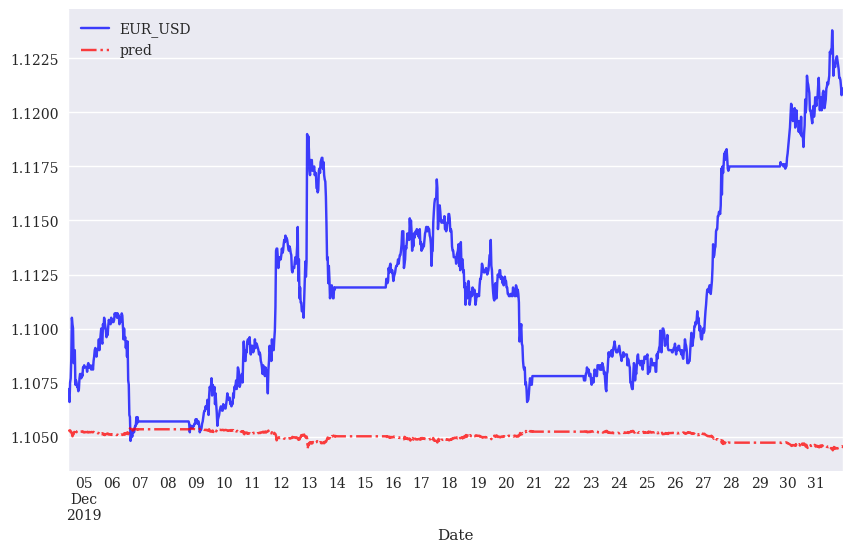

In [40]:
# test on the testing data 
y = model.predict(g_, verbose=False)

# recover from the normalization
y = (y.flatten()*train_std) + train_avg

# testing results also have lags
data['pred'].iloc[split+lags:] = y

MSE = ((data.iloc[split+lags:]['EUR_USD']-data.iloc[split+lags:]['pred'])**2).mean()
print(f'RNN Testing MSE={MSE:.10f} ')

data[['EUR_USD', 'pred']].iloc[split+lags:].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);

<AxesSubplot: xlabel='Date'>

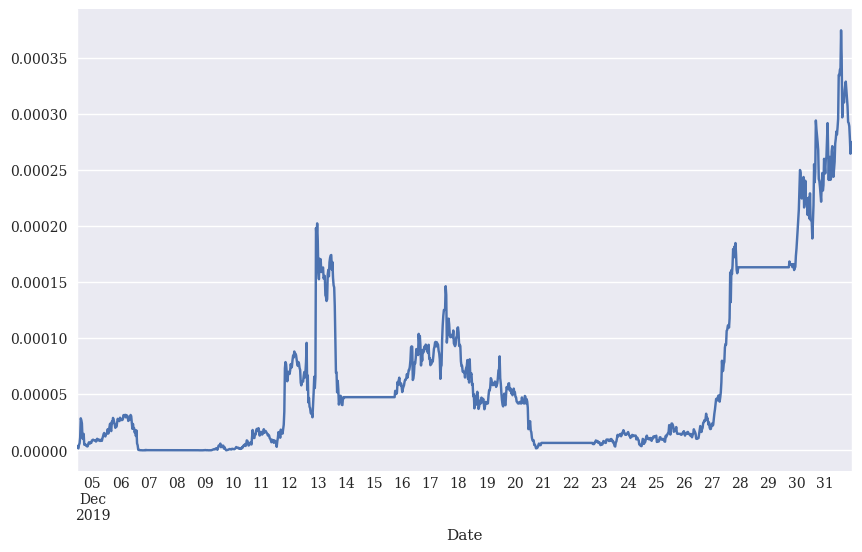

In [41]:
# testing errors
test_error = ((data.iloc[split+lags:]['EUR_USD']-data.iloc[split+lags:]['pred'])**2)

data['Tst_Error'] = np.nan
data['Tst_Error'].iloc[split+lags:] = test_error
data['Tst_Error'].iloc[split+lags:].plot( figsize=(10, 6) )

### Modelling FX return

,EUR_USD
Date,
2019-10-01 02:00:00,1.0890
2019-10-01 04:00:00,1.0888
2019-10-01 06:00:00,1.0887
2019-10-01 08:00:00,1.0885
2019-10-01 10:00:00,1.0892


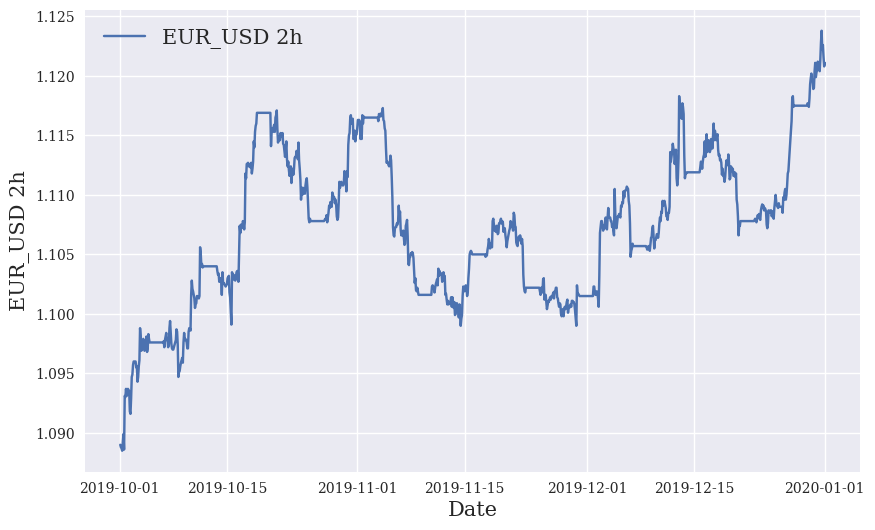

In [42]:
# re-sampling the data
freq = '2h'
data = generate_data( freq )
plot_fin_data(data.index, data[['EUR_USD']], 'EUR_USD '+freq)
data.head()

In [43]:
# calculate the log return
data['r'] = np.log(data / data.shift(1))
data.head()

,EUR_USD,r
Date,,
2019-10-01 02:00:00,1.0890,NaN
2019-10-01 04:00:00,1.0888,-0.000184
2019-10-01 06:00:00,1.0887,-0.000092
2019-10-01 08:00:00,1.0885,-0.000184
2019-10-01 10:00:00,1.0892,0.000643


In [44]:
# drop the row containing NaN 
data.dropna(inplace=True)
data.head()

,EUR_USD,r
Date,,
2019-10-01 04:00:00,1.0888,-0.000184
2019-10-01 06:00:00,1.0887,-0.000092
2019-10-01 08:00:00,1.0885,-0.000184
2019-10-01 10:00:00,1.0892,0.000643
2019-10-01 12:00:00,1.0899,0.000642


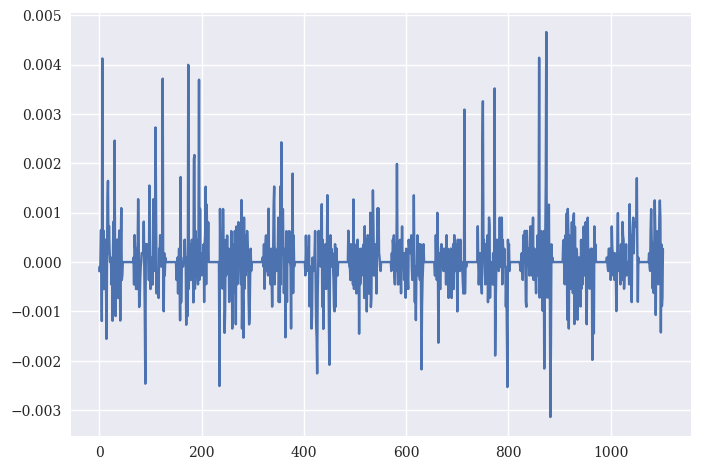

In [45]:
r = data['r'].values
plt.plot(r)

In [46]:
r = r.reshape((len(r), -1))
r.shape

(1103, 1)

In [47]:
# split is the break point; first 70% for training, remained 30% for testing
split = int(len(r)*0.7)

In [48]:
r_train_avg = r[:split].mean()
r_train_std = r[:split].std()

# normalize by mean and std of training data
r_train = (r[:split]-r_train_avg)/r_train_std

r_train[:6]

array([[-0.3156],
       [-0.1742],
       [-0.3156],
       [ 0.9574],
       [ 0.9567],
       [-1.8707]])

In [49]:
g_r = TimeseriesGenerator(r_train, r_train, length=lags, batch_size=5)

x,y = g_r[0]
print('%s => %s' % (x, y))    

[[[-0.3156]
  [-0.1742]
  [-0.3156]]

 [[-0.1742]
  [-0.3156]
  [ 0.9574]]

 [[-0.3156]
  [ 0.9574]
  [ 0.9567]]

 [[ 0.9574]
  [ 0.9567]
  [-1.8707]]

 [[ 0.9567]
  [-1.8707]
  [ 6.3203]]] => [[ 0.9574]
 [ 0.9567]
 [-1.8707]
 [ 6.3203]
 [-0.1736]]


In [50]:
model_rtn = create_rnn_model()
model_rtn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [51]:
%%time
model_rtn.fit(g_r, epochs=50, verbose=False)

2023-01-23 00:42:02.329012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 1min 51s, sys: 1min 12s, total: 3min 4s
Wall time: 1min 33s


In [52]:
# test the model by training data 
y_rtn = model_rtn.predict(g_r, verbose=False)

# recover from the normalization
y_rtn = (y_rtn.flatten()*r_train_std) + r_train_avg
y_rtn[:10]

2023-01-23 00:43:36.101934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([ 0.0002,  0.0004, -0.0004,  0.001 ,  0.0001,  0.0007, -0.0001,
        0.    ,  0.    ,  0.0001], dtype=float32)

In [53]:
data['pred'] = np.nan
data['pred'].iloc[lags:split] = y_rtn

MSE = ((data.iloc[lags:split]['r']-data.iloc[lags:split]['pred'])**2).mean()

# MSE = ((data['EUR_USD']-data['pred'])**2).iloc[lags:].mean()
print(f'RNN return Training MSE={MSE:.20f} ')

RNN return Training MSE=0.00000033436202368874 


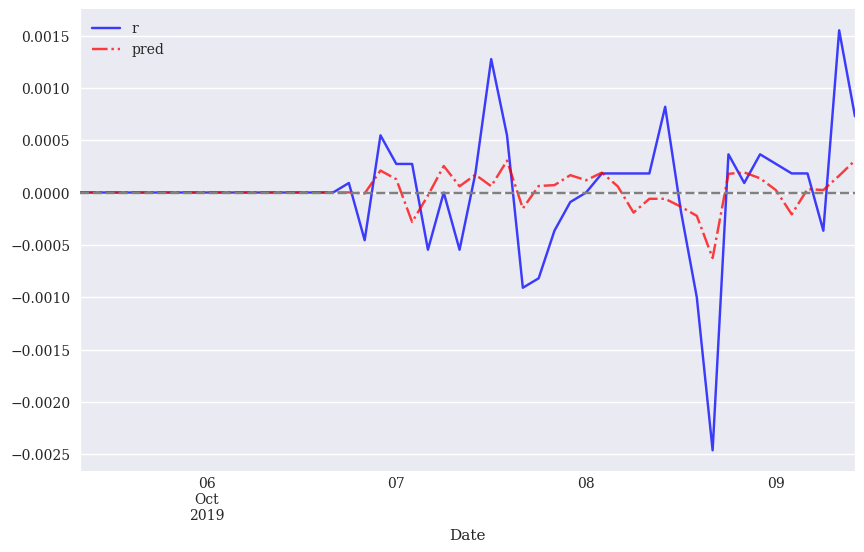

In [54]:
data[['r', 'pred']].iloc[50:100].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);
plt.axhline(0, c='grey', ls='--');

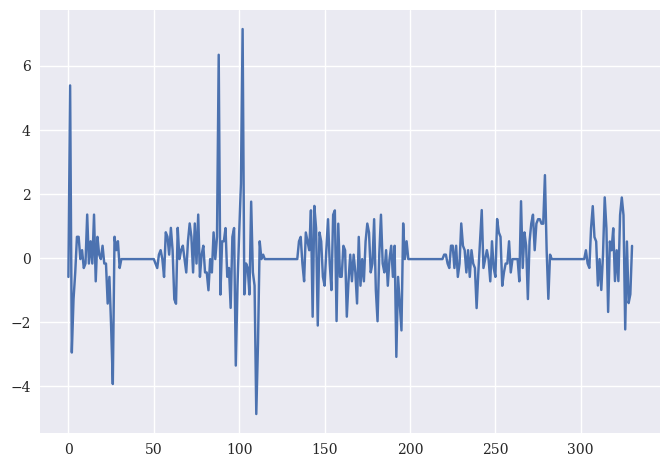

In [55]:
# using test data

# normalize the test data by training mean and std
r_test = (r[split:]-r_train_avg)/r_train_std
plt.plot(r_test)

In [56]:
g_r_ = TimeseriesGenerator(r_test, r_test, length=lags, batch_size=5)

# to print the first example of generated X and y
x,y = g_r_[0]
print('%s => %s' % (x, y))

[[[-0.5893]
  [ 5.3853]
  [-2.9477]]

 [[ 5.3853]
  [-2.9477]
  [-1.2837]]

 [[-2.9477]
  [-1.2837]
  [-0.4499]]

 [[-1.2837]
  [-0.4499]
  [ 0.6626]]

 [[-0.4499]
  [ 0.6626]
  [ 0.6623]]] => [[-1.2837]
 [-0.4499]
 [ 0.6626]
 [ 0.6623]
 [-0.0327]]


In [57]:
# test the model by training data 
y_rtn_ = model_rtn.predict(g_r_, verbose=False)

# recover from the normalization
y_rtn_ = (y_rtn_.flatten()*r_train_std) + r_train_avg
y_rtn_[:10]

array([-0.0006, -0.0002,  0.0001,  0.0001, -0.0004,  0.0001,  0.    ,
        0.    ,  0.    ,  0.0004], dtype=float32)

In [58]:
data['pred'].iloc[split+lags:] = y_rtn_

MSE = ((data.iloc[split+lags:]['r']-data.iloc[split+lags:]['pred'])**2).mean()

# MSE = ((data['EUR_USD']-data['pred'])**2).iloc[lags:].mean()
print(f'RNN return Test MSE={MSE:.20f} ')

RNN return Test MSE=0.00000048794056808100 


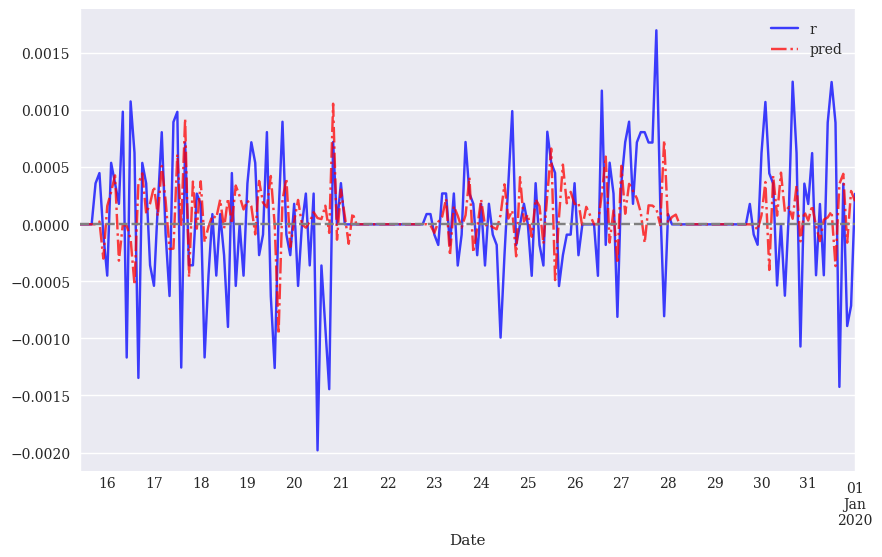

In [59]:
# plot the last 200 items

data[['r', 'pred']].iloc[-200:].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);
plt.axhline(0, c='grey', ls='--');

### Modelling Financial Features by RNN / LSTM

In [ ]:
# re-sampling the data
freq = '30min'
data = generate_data( freq )
plot_fin_data(data.index, data[['EUR_USD']], 'EUR_USD '+freq)
data.head()

In [ ]:
data['r'] = np.log(data / data.shift(1))

In [ ]:
# calculating the sliding window feature
window = 20
# momentum of past 20 intervals
data['mom'] = data['r'].rolling(window).mean()
# volatility in past 20 intervals
data['vol'] = data['r'].rolling(window).std()
# 
data.head(window+5)

In [ ]:
# remove the NaN
data.dropna(inplace=True)
data.head()

In [ ]:
split = int(len(data) * 0.7)

In [ ]:
# construct and normalize training and testing dataset
f_train_mu = data.iloc[:split].mean()
f_train_vol = data.iloc[:split].std()
print(f_train_mu)
print(f_train_vol)

f_train_data = (data.iloc[:split]-f_train_mu)/f_train_vol
f_test_data = (data.iloc[split:]-f_train_mu)/f_train_vol

print(f_train_data.head())
print(f_test_data.head())

In [ ]:
f_train_data.values[:10]

In [ ]:
# make 5-lagged features as the X
''' batch_size is batch size defines the number samples that will be fed in each iteration of the model.
The difference between the different values of batch size are the model weight's optimization. 
If batch size is equal to 3, the model update the weights only after reading 3 samples.
'''

g_f = TimeseriesGenerator(f_train_data.values, f_train_data['r'].values,
                        length=lags, batch_size=2)

# to print the first example of generated X and y
'''
                                X               y
[[[-2.5306  2.0449 -0.0129  0.4676]
  [-2.547  -0.2718  0.119   0.445 ]
  [-2.4488  1.5292  0.7781  0.4771]
  [-2.547  -1.5581  0.5147  0.5712]
  [-2.6452 -1.559   0.383   0.625 ]]        0.5005
to forecast 6-th return 0.5005
all features in prior 5 points are required
'''
x,y = g_f[1]
print('%s => %s' % (x, y))

In [ ]:
set_seeds()
model_f = create_rnn_model( features=len(f_train_data.columns) )
model_f.summary()

In [ ]:
# you may revise epochs=100 for better accuracy with training time longer than 10min
%%time
model_f.fit(g_f, epochs=10, verbose=False)

In [ ]:
# construct data for testing

g_f_ = TimeseriesGenerator(f_test_data.values, f_test_data['r'].values,
                         length=lags, batch_size=2)

In [ ]:
y_f = model_f.predict(g_f_)

# recover from the normalization
y_f = (y_f.flatten()* f_train_vol['r'] ) + f_train_mu['r']
print(y_f[:5])

# add testing results to pred column
data['pred'] = np.nan
data['pred'].iloc[split+lags:] = y_f

MSE = ((data.iloc[split+lags:]['r']-data.iloc[split+lags:]['pred'])**2).mean()
print(f'RNN return Test MSE={MSE:.20f} ')

data.tail()

In [ ]:
# plot the last 100 items

data[['r', 'pred']].iloc[-100:].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);
plt.axhline(0, c='grey', ls='--');

### Modelling by Deep RNN Model

*   this example follows the prior "Modelling Financial Features by RNN / LSTM" example
*   the constructed g_f is used for training, g_f_ is used for testing




In [ ]:
'''define deep RNN model with multiple hidden layers
for the nonfinal hidden layers, the parameter return_sequences is set to True 
hl: number of hidden layers
hu: number of hidden units
'''
from keras.layers import Dropout

def create_deep_rnn_model(hl=2, hu=100, layer='SimpleRNN',
                          optimizer='rmsprop', features=1,
                          dropout=False, rate=0.3, seed=100):
    if hl <= 2: hl = 2
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
    model = Sequential()
    model.add(layer(hu, input_shape=(lags, features),
                     return_sequences=True, ))
    if dropout:
        model.add(Dropout(rate, seed=seed))
    for _ in range(2, hl):
        model.add(layer(hu, return_sequences=True))
        if dropout:
            model.add(Dropout(rate, seed=seed))
    model.add(layer(hu))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # model.compile(optimizer=optimizer,
    #               loss='binary_crossentropy',
    #               metrics=['accuracy'])
    return model

In [ ]:
set_seeds()
model_deep = create_deep_rnn_model(
              hl=2, 
              hu=50, layer='SimpleRNN',
              features=len(f_train_data.columns), 
              dropout=True, rate=0.3) 
model_deep.summary()


In [ ]:
# training takes long time... around 15 mins

%%time
model_deep.fit(g_f, epochs=100,  verbose=False)

In [ ]:
y_deep = model_deep.predict(g_f_)

# recover from the normalization
y_deep = (y_deep.flatten()* f_train_vol['r'] ) + f_train_mu['r']

# add column of prediction
result_deep = data[['r']].copy()
result_deep['pred'] = np.nan
result_deep['pred'].iloc[split+lags:] = y_deep

MSE = ((result_deep.iloc[split+lags:]['r']-result_deep.iloc[split+lags:]['pred'])**2).mean()
print(f'Deep RNN return Test MSE={MSE:.20f} ')

In [ ]:
# plot the last 200 items

result_deep[['r', 'pred']].iloc[-200:].plot(
            figsize=(10, 6), style=['b', 'r-.'],
            alpha=0.75);
plt.axhline(0, c='grey', ls='--');